### Purchasing patterns (Analysing the data, Task 3)

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [136]:
file_path = '../data/Superstore Dataset.xlsx'
df = pd.read_excel(file_path, sheet_name='Orders')

In [137]:
df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,US-2019-103800,2019-01-03,2019-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512


In [138]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32484 entries, 0 to 32483
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         32484 non-null  int64         
 1   Order ID       32484 non-null  object        
 2   Order Date     32484 non-null  datetime64[ns]
 3   Ship Date      32484 non-null  datetime64[ns]
 4   Ship Mode      32484 non-null  object        
 5   Customer ID    32484 non-null  object        
 6   Customer Name  32484 non-null  object        
 7   Segment        32484 non-null  object        
 8   Country        32484 non-null  object        
 9   City           32484 non-null  object        
 10  State          32484 non-null  object        
 11  Postal Code    32482 non-null  object        
 12  Region         32484 non-null  object        
 13  Product ID     32484 non-null  object        
 14  Category       32484 non-null  object        
 15  Sub-Category   3248

## sales trends

Let's see how the sale trends look like

In [140]:
def sales_trends(df, group_by, log_scale=False):
    aggregated_sales = df.groupby([group_by, df['Order Date'].dt.to_period('M')])['Sales'].sum().unstack(level=0)
    
    plt.figure(figsize=(18, 8))
    for column in aggregated_sales.columns:
        plt.plot(aggregated_sales.index.to_timestamp(), aggregated_sales[column], label=column)
    
    plt.title(f'Monthly Sales Trend by {group_by}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    if log_scale:
        plt.yscale('log')
    plt.legend(title=group_by, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

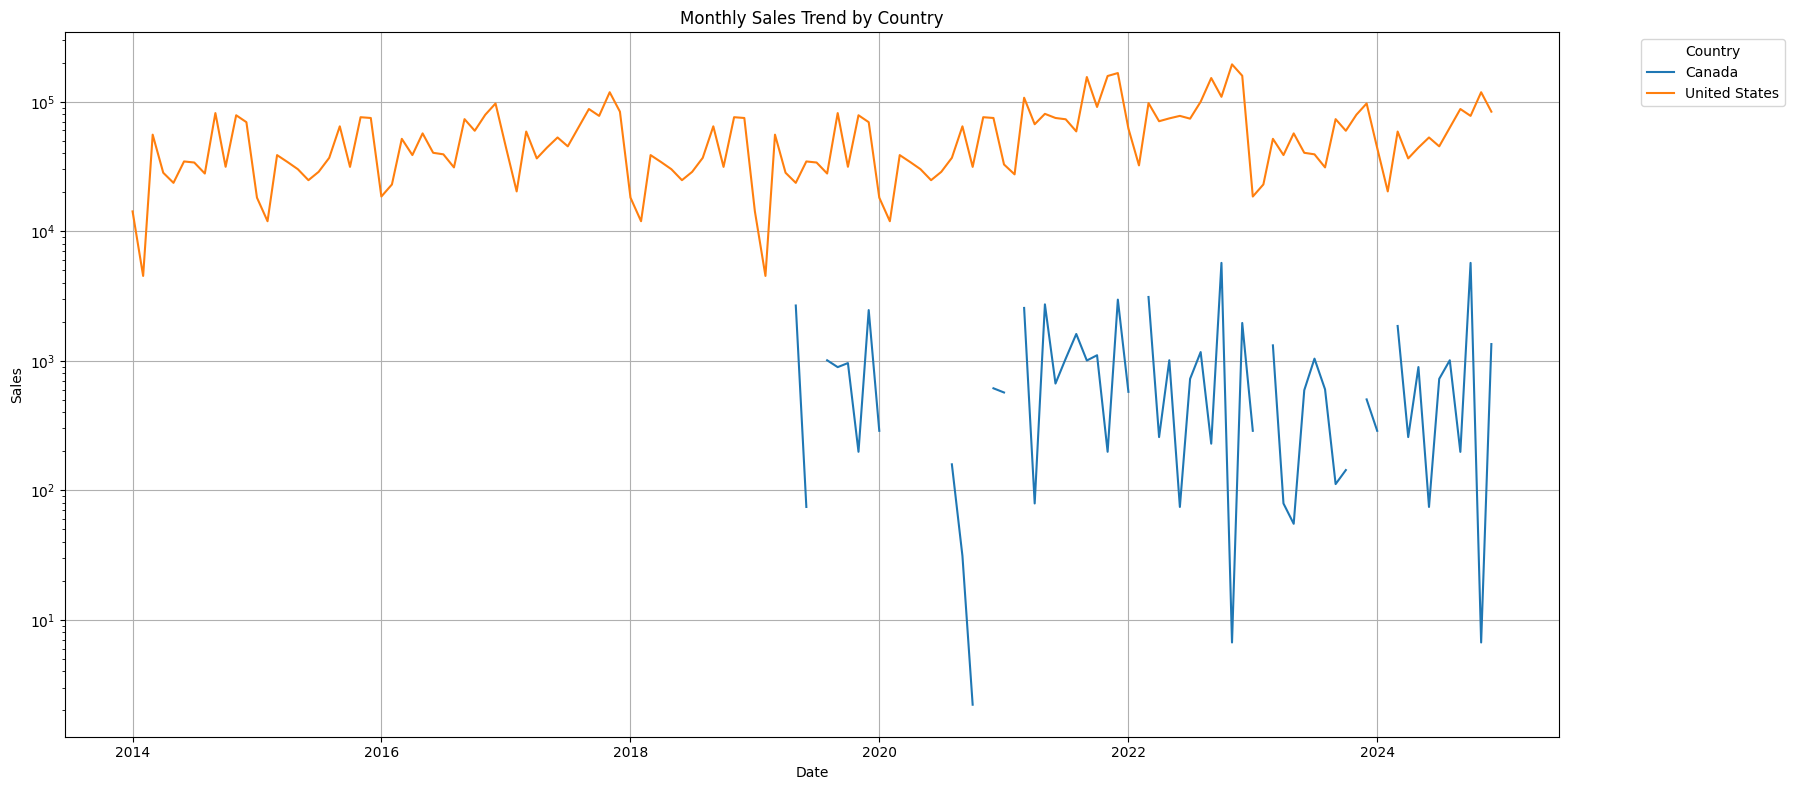

In [141]:
sales_trends(df, 'Country', log_scale=True) #using log here as the sales in canada is super small

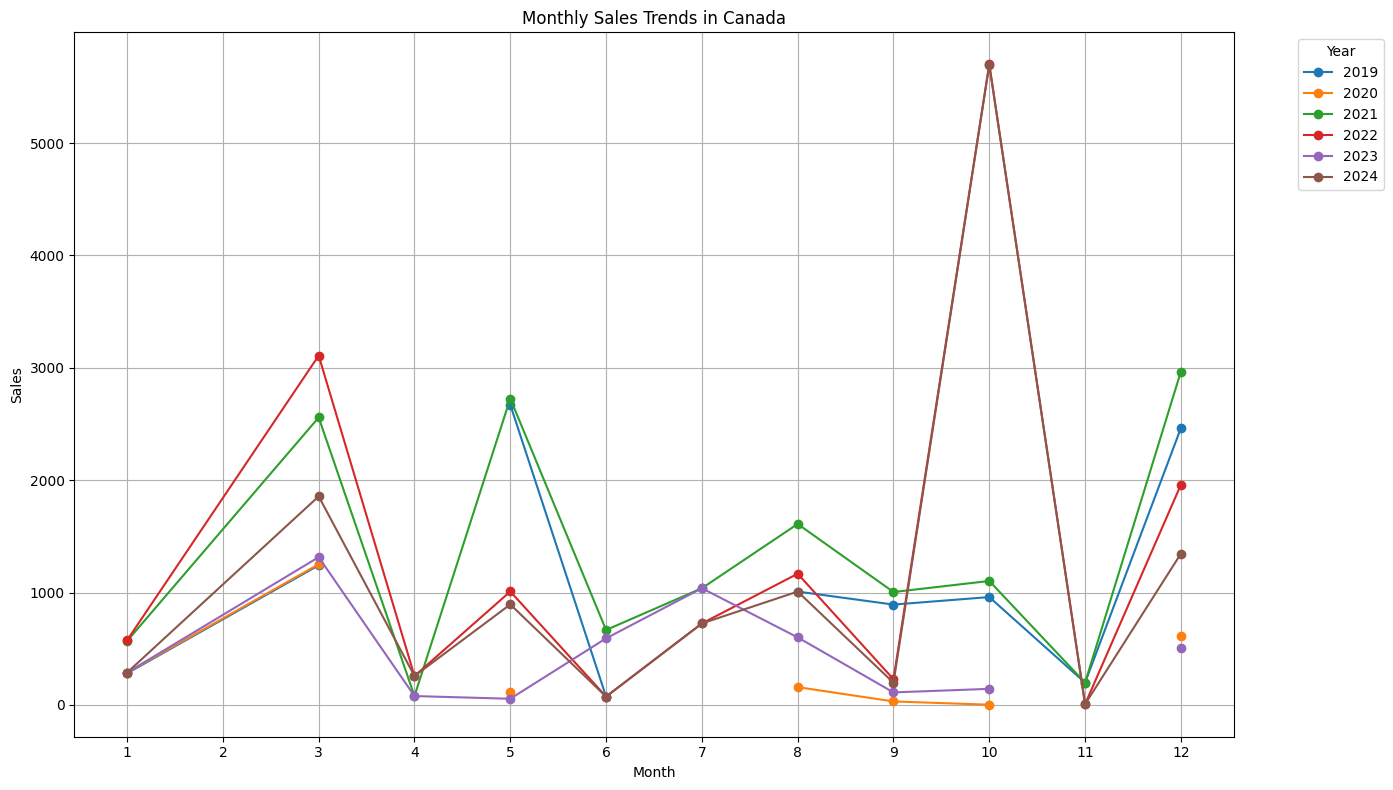

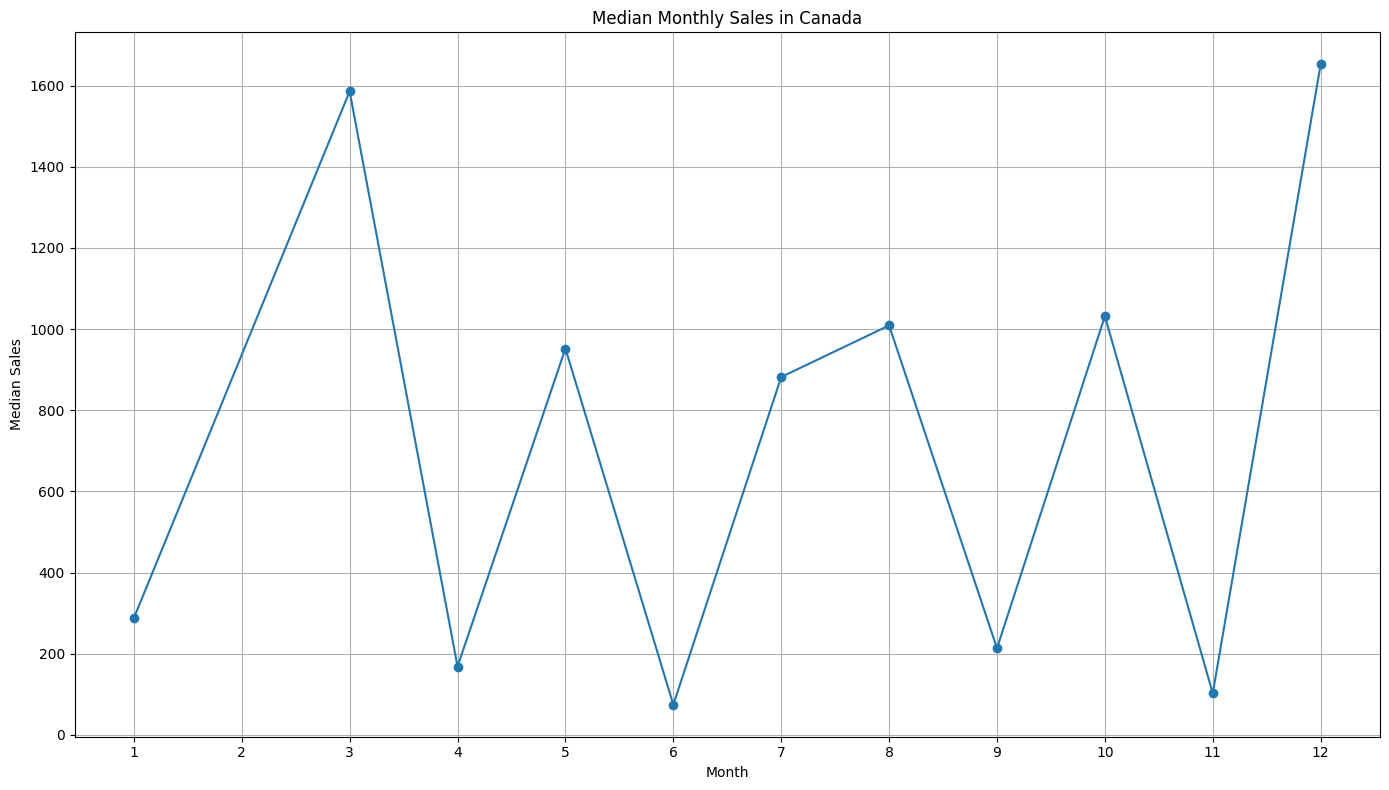

In [142]:
# Filter data for Canada
canada_sales_df = df[df['Country'] == 'Canada']

# Check if there are any sales in Canada
if canada_sales_df.empty:
    print("There are no sales in Canada.")
else:
    # Aggregate sales by year and month
    canada_sales_df['Year'] = canada_sales_df['Order Date'].dt.year
    canada_sales_df['Month'] = canada_sales_df['Order Date'].dt.month
    monthly_sales = canada_sales_df.groupby(['Year', 'Month'])['Sales'].sum().unstack(level=0)
    
    # Plot sales trends
    plt.figure(figsize=(14, 8))
    for year in monthly_sales.columns:
        plt.plot(monthly_sales.index, monthly_sales[year], marker='o', linestyle='-', label=str(year))
    
    plt.title('Monthly Sales Trends in Canada')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.xticks(range(1, 13))
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Check consistency of sales month-over-month
    avg_monthly_sales = monthly_sales.median(axis=1)
    plt.figure(figsize=(14, 8))
    plt.plot(avg_monthly_sales.index, avg_monthly_sales, marker='o', linestyle='-', label='Median Monthly Sales') # using median here to offset the outliers
    
    plt.title('Median Monthly Sales in Canada')
    plt.xlabel('Month')
    plt.ylabel('Median Sales')
    plt.xticks(range(1, 13))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

It is visible that on average the highest sales are in March and December. Maybe there is some correlation between holidays period (Christmas etc.)

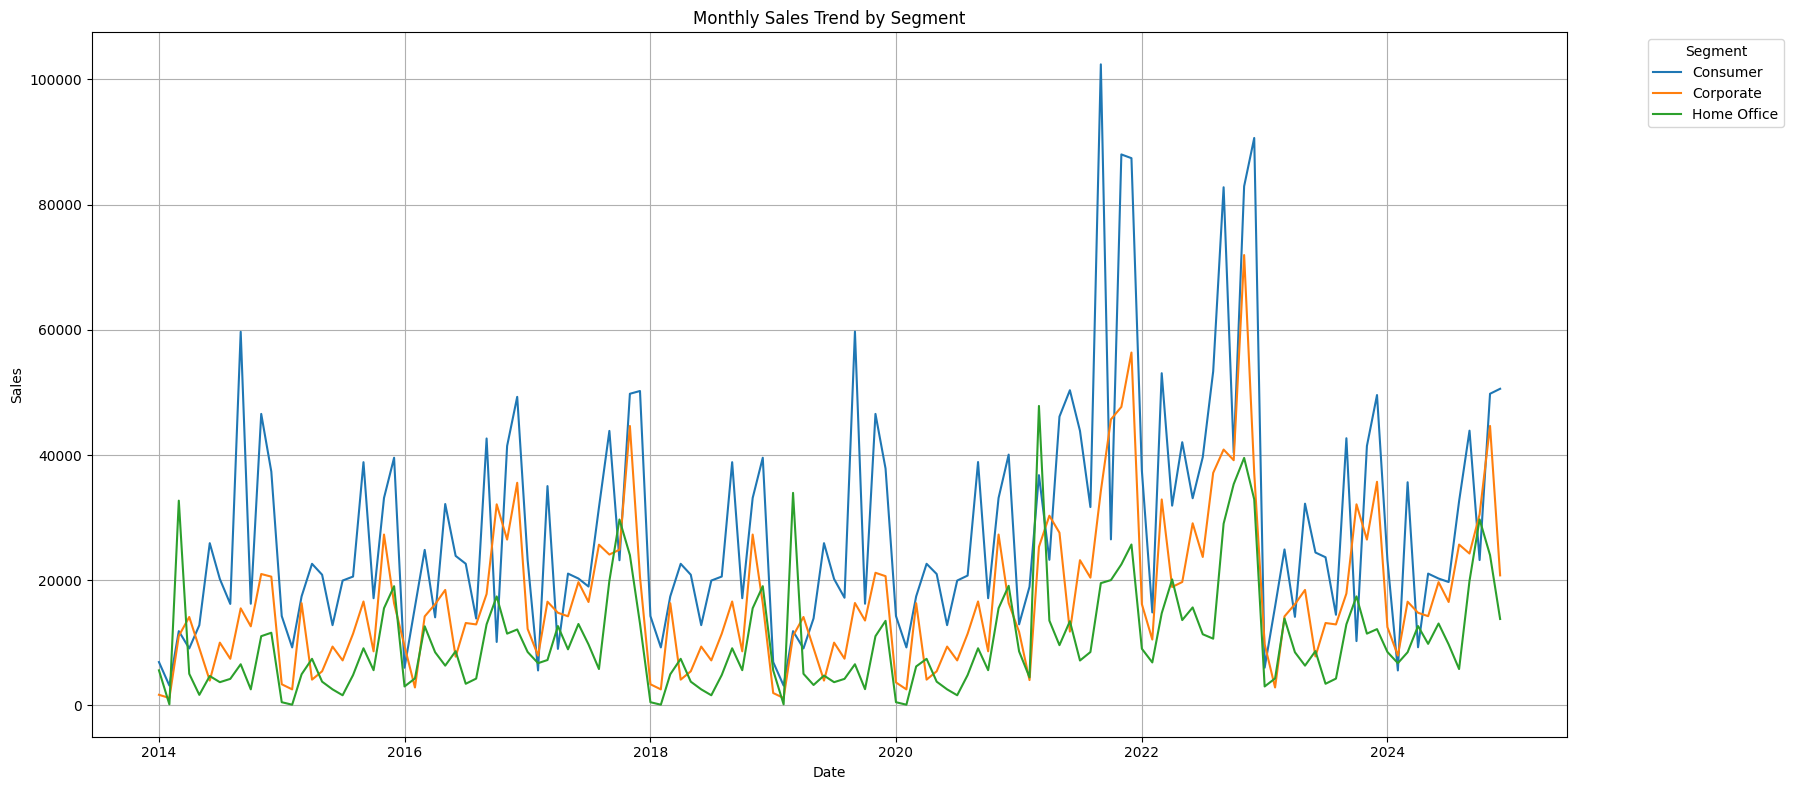

In [143]:
sales_trends(df, 'Segment')

In [144]:
def median_monthly_sales_per_segment(df):
    # Extract year and month from 'Order Date'
    df['Year'] = df['Order Date'].dt.year
    df['Month'] = df['Order Date'].dt.month

    # Aggregate sales by segment, year, and month
    segment_sales = df.groupby(['Segment', 'Year', 'Month'])['Sales'].sum().reset_index()

    # Calculate the median monthly sales for each segment
    median_monthly_sales = segment_sales.groupby(['Segment', 'Month'])['Sales'].median().unstack(level=0)

    # Plot the median monthly sales trends for each segment
    plt.figure(figsize=(14, 8))
    for segment in median_monthly_sales.columns:
        plt.plot(median_monthly_sales.index, median_monthly_sales[segment], marker='o', linestyle='-', label=segment)
    
    plt.title('Median Monthly Sales Trends by Segment')
    plt.xlabel('Month')
    plt.ylabel('Median Sales')
    plt.xticks(range(1, 13))
    plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

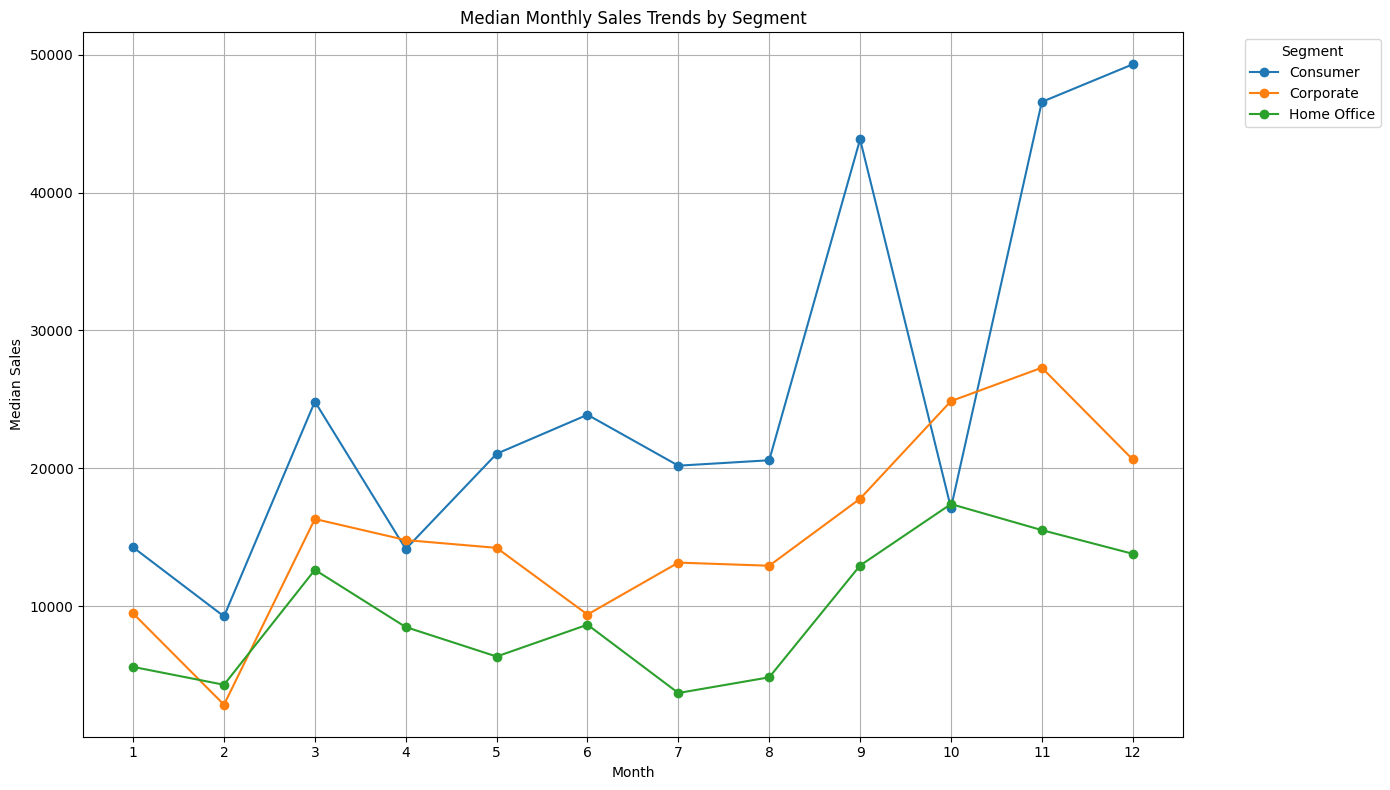

In [145]:
median_monthly_sales_per_segment(df)

Again it's show the highest demans is in December. Additionally it's shown that there is increased activity in September.
These can be corresponding to events such as: new academic year and Christmas.

In [16]:
def top_growing_cities(df, top_n=10):
    df['Month'] = df['Order Date'].dt.to_period('M')
    monthly_sales = df.groupby(['City', 'Month'])['Sales'].sum().unstack(level=0)
    
    # Calculate the monthly growth rate
    monthly_growth = monthly_sales.pct_change().mean().sort_values(ascending=False).head(top_n)
    top_cities = monthly_growth.index
    
    # Filter the data for the top growing cities
    top_cities_sales = monthly_sales[top_cities]

    plt.figure(figsize=(14, 8))
    for city in top_cities_sales.columns:
        plt.plot(top_cities_sales.index.to_timestamp(), top_cities_sales[city], label=city)
    
    plt.title(f'Top {top_n} Highest Growing Cities by Monthly Sales Growth')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/fh/7sz134vx5jq6_78w16smcs3h0000gn/T/ipykernel_89651/2129136072.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_growth = monthly_sales.pct_change().mean().sort_values(ascending=False).head(top_n)


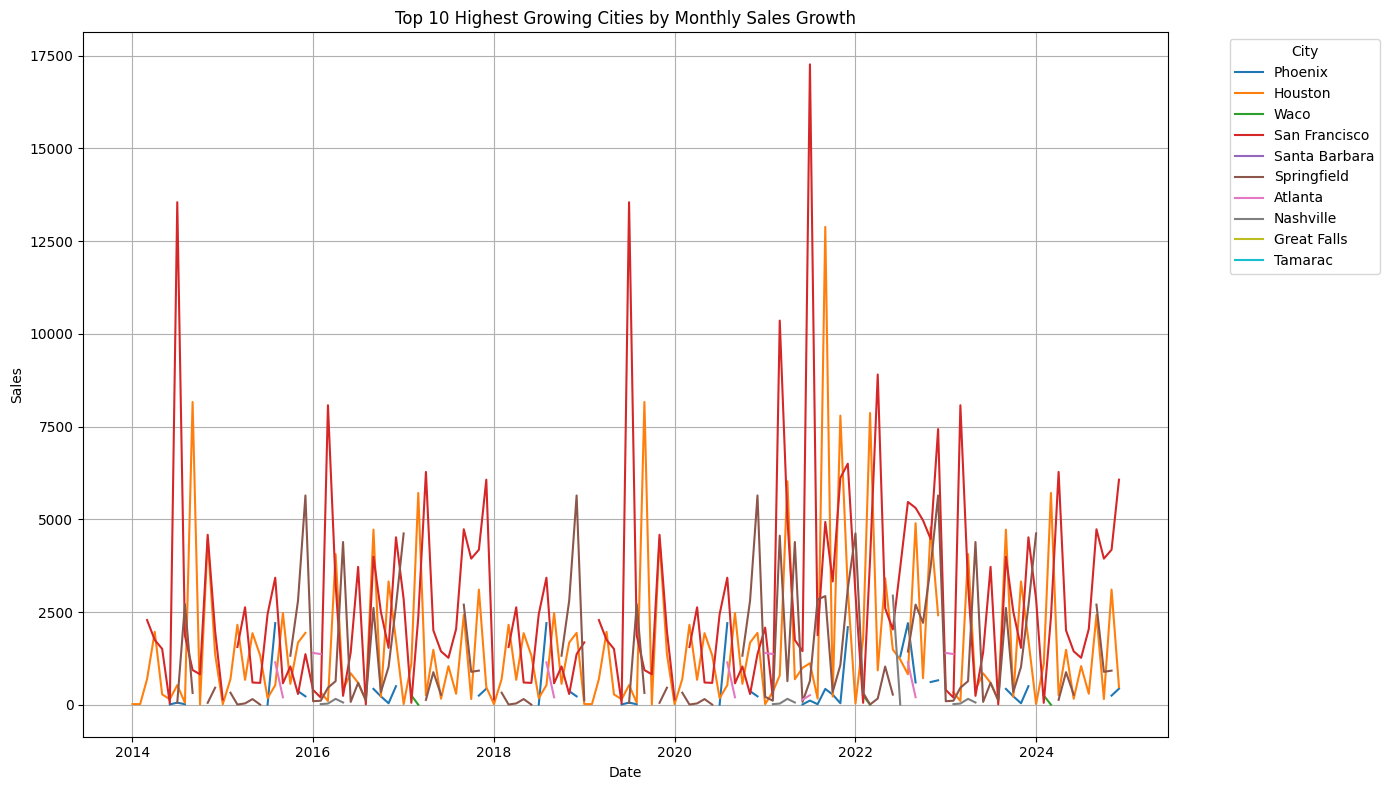

In [46]:
top_growing_cities(df, top_n=10)

To confirm hypothesis about correlation between high sales in September and the start of new academic year, it would be good to see data on number of children that each customer has.

## Frequency of each category
Let's see how frequent it is to order an item in each category and sub-category

In [184]:
def favourite_product_category(df, column_name, bins_no=20):
    # Group by a specific column and create histograms for each group
    df4 = (df.groupby(['Segment', column_name])['Quantity']
         .agg('sum')).reset_index()
    
    print(df4)
    
    grouped = df4.groupby(column_name)
    
    
    
    
    plt.figure()
    plt.title(f'Histogram for total {column_name}')
    plt.ylabel('Frequency')
    plt.xticks(rotation=60) 
    for group_name, group_data in grouped:
        group_data[column_name].hist()
    plt.show()
    
    
    grouped = df.groupby("Segment")

    
    plt.figure()
    plt.title(f'Histogram for Group each {column_name}')
    plt.ylabel('Frequency')
    plt.xticks(rotation=50) 
    print(len(grouped))
    for group_name, group_data in grouped:
        group_data[column_name].hist(width=0.2, bins = bins_no)
        plt.legend(grouped.groups.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()



In [183]:
favourite_product_category(df, "Category")

       Segment         Category  Quantity
0     Consumer        Furniture     13649
1     Consumer  Office Supplies     38189
2     Consumer       Technology     11643
3    Corporate        Furniture      8306
4    Corporate  Office Supplies     22681
5    Corporate       Technology      6830
6  Home Office        Furniture      4586
7  Home Office  Office Supplies     13287
8  Home Office       Technology      3989


TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.groupby.generic.DataFrameGroupBy'>.

        Segment Sub-Category  Quantity
0      Consumer  Accessories      5101
1      Consumer   Appliances      2945
2      Consumer          Art      5292
3      Consumer      Binders      9845
4      Consumer    Bookcases      1654
5      Consumer       Chairs      4065
6      Consumer      Copiers       384
7      Consumer    Envelopes      1442
8      Consumer    Fasteners      1591
9      Consumer  Furnishings      5969
10     Consumer       Labels      2305
11     Consumer     Machines       713
12     Consumer        Paper      8370
13     Consumer       Phones      5445
14     Consumer      Storage      5251
15     Consumer     Supplies      1148
16     Consumer       Tables      1961
17    Corporate  Accessories      2792
18    Corporate   Appliances      1804
19    Corporate          Art      2808
20    Corporate      Binders      5937
21    Corporate    Bookcases       877
22    Corporate       Chairs      2305
23    Corporate      Copiers       235
24    Corporate    Envelo

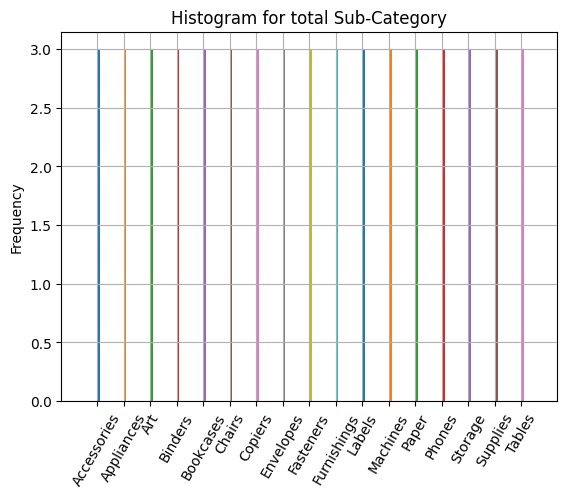

3


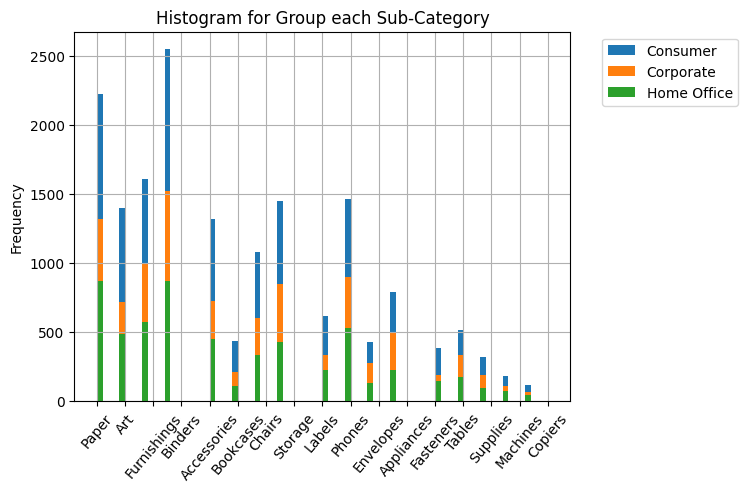

In [185]:
favourite_product_category(df, "Sub-Category")

Let's see how many customers with more than 1 order there are.

In [151]:
aggregated_data = df.groupby(["Order ID",'Customer ID'])

aggregated_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Year,Month
0,1,US-2019-103800,2019-01-03,2019-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512,2019,1
1,2,US-2019-112326,2019-01-04,2019-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870,2019,1
2,3,US-2019-112326,2019-01-04,2019-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717,2019,1
3,4,US-2019-112326,2019-01-04,2019-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748,2019,1
4,5,US-2019-141817,2019-01-05,2019-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32479,32480,CA-2018-103772,2018-06-28,2018-07-02,Standard Class,MP-17470,Mark Packer,Home Office,United States,Smyrna,...,OFF-BI-10002867,Office Supplies,Binders,GBC Recycled Regency Composition Covers,119.560,2,0.0,54.9976,2018,6
32480,32481,CA-2018-103772,2018-06-28,2018-07-02,Standard Class,MP-17470,Mark Packer,Home Office,United States,Smyrna,...,OFF-AR-10000538,Office Supplies,Art,"Boston Model 1800 Electric Pencil Sharpener, Gray",140.750,5,0.0,42.2250,2018,6
32481,32482,US-2018-151435,2018-09-06,2018-09-09,Second Class,SW-20455,Shaun Weien,Consumer,United States,Lafayette,...,FUR-TA-10001039,Furniture,Tables,KI Adjustable-Height Table,85.980,1,0.0,22.3548,2018,9
32482,32483,CA-2018-100251,2018-05-17,2018-05-23,Standard Class,DV-13465,Dianna Vittorini,Consumer,United States,Long Beach,...,OFF-LA-10003766,Office Supplies,Labels,Self-Adhesive Removable Labels,31.500,10,0.0,15.1200,2018,5


### Conclusions from data

The months of high activity are March, September and December. September may be correlated to the start of the academic year and December to Christmas (gifts etc.).

From frequency of buying: "Office supplies" is the popular category among every Segment. "Consumer" has the biggest impact on the frequency of buying. Binders, Paper and Furnishing are the most popular subcategories.